# Self-Driving Car Engineer Nanodegree

## Project: **Finding Lane Lines on the Road** 


## Helper Functions

Following helper functions are as is and there is no change in them

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros(img.shape, img.dtype)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


## Pipeline

**process_image**:

Makes the image grayscale, runs Canny on the grayscale image, masks boundary, runs hough edge detection, which in turn calls draw lines

**draw_lines**:

**Left lane** lines are the ones whose start line segment lie to the left of the center of the frame and **right lane** lines are the ones that lie to the right of the center of the frame.

It finds the weighted average slope of each small line segment, where the weight is how big the line segment is. Once the slope is found **C** is found using the biggest line segment in the equation (Y = MX + C)

In [5]:
import cv2
import pdb
import os

def process_image(image):
    # remove any alpha channel from the image and just keep the RGB
    image = image[:,:,:3]
    
    gray = grayscale(image)
    gray_blur = gaussian_blur(gray, 5)
    edges = canny(gray_blur, 50, 150)
    
    vertices = mask_boundary(edges.shape)
    masked_edges = region_of_interest(edges, vertices)
    
    lines_image = hough_lines(masked_edges, 2, np.pi / 180.0, threshold = 40, min_line_len = 30, max_line_gap = 30)
    
    lanes = weighted_img(lines_image, image)
    return lanes

def mask_boundary(shape):
    size_y, size_x = shape
    return np.array([[(size_x * 0.10, size_y), \
                      (size_x * 0.45, size_y * 0.60),\
                      (size_x * 0.55, size_y * 0.60), \
                      (size_x * 0.97, size_y)]], dtype=np.int32)

def draw_lines(img, lines, thickness=10, draw_hough_edges = True):
    if draw_hough_edges:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1,y1), (x2,y2), [255,0,0], thickness)

    size_y, size_x,_ = img.shape
    center_x = size_x / 2
  
    # all lines that start from to the left of the center of the frame might be 
    # left lane lines
    left_lines = lines[lines[:,0,0] <= center_x]
    
    # all lines that end at the right side of the frame are right lane lines
    right_lines = lines[lines[:,0,2] > center_x]
    
    # average out the slope of all line segments in a lane
    # and then draw an line from the bottom of the lane to the top
    left_lane_eq = avg_lane_equation(left_lines)
    right_lane_eq = avg_lane_equation(right_lines)
    
    # extrapolate a line from the bottom of the frame to the center
    # for both left and right lanes

    left_lane = extrapolate_lane(left_lane_eq, size_y, size_y * 0.6)
    right_lane = extrapolate_lane(right_lane_eq, size_y, size_y * 0.6)
        
    cv2.line(img, left_lane[0], left_lane[1], [0,0,255], thickness + 12)
    cv2.line(img, right_lane[0], right_lane[1], [0,0,255], thickness + 12)
    
    return img

def extrapolate_lane(line_eq, frame_bottom, frame_top):
    M, C = line_eq
    
    # Y = MX + C
    # bottom lane line, we know Y = size of frame, find out X
    # X = (Y - C) / M
    
    bottom_pt = (int((frame_bottom - C) / M), int(frame_bottom))
    top_pt = (int((frame_top - C) / M), int(frame_top))
    
    return (bottom_pt, top_pt)

def avg_lane_equation(lines):
    # returns a tuple (M, C) representing line equation Y = mX + C
    # M -> is the slope of a line that is weighted average of all smaller line segments
    # C -> constant in the line equation (y = mx + c)
    
    # Y = MX + C
    # M = (y2 - y1) / (x2 - x1)
    # take a weighted average of all slopes. The bigger the line segment
    # the bigger its weight
    
    slopes = ((lines[:,0,3] - lines[:,0,1]) / (lines[:,0,2] - lines[:,0,0]))
    distance = ((lines[:,0,2] - lines[:,0,0]) ** 2) + ((lines[:,0,3] - lines[:,0,1]) ** 2)
    slope_avg = np.average(slopes, weights = distance)
    
    # C = Y - MX
    # Use the line segment that is biggest in the given lines
    
    biggest_line_segment = np.argmax(distance)
    
    # C = Y - MX
    C = lines[biggest_line_segment,0,3] - slope_avg * lines[biggest_line_segment,0,2]
    return (slope_avg, C)


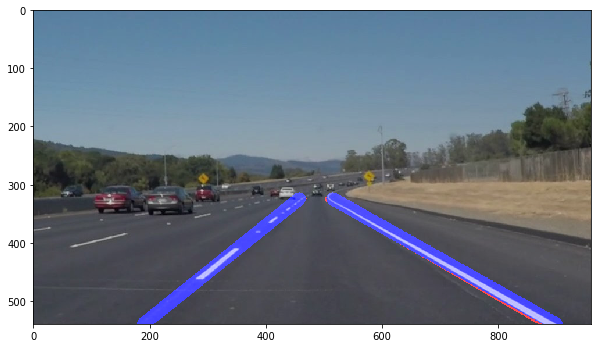

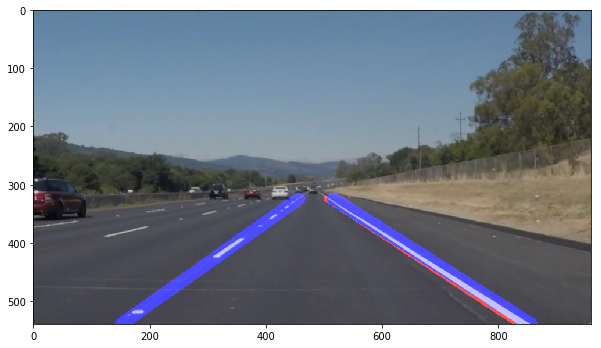

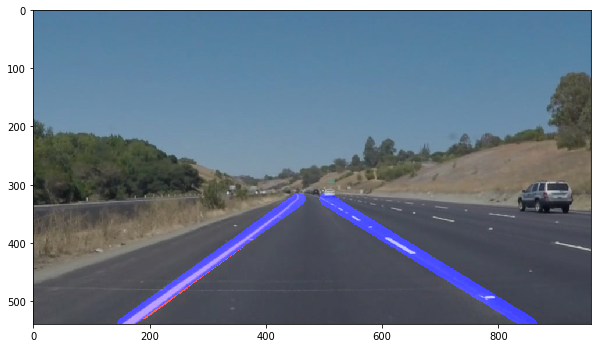

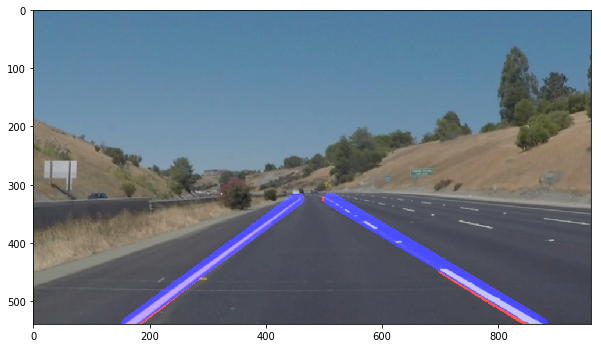

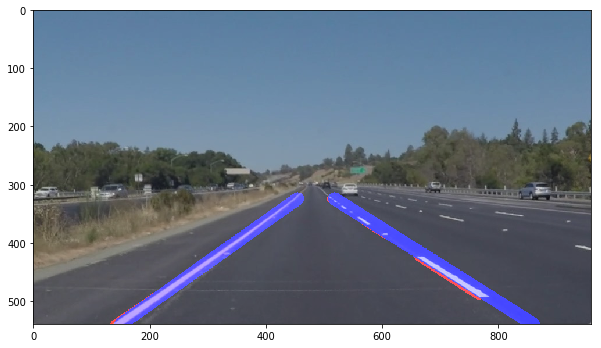

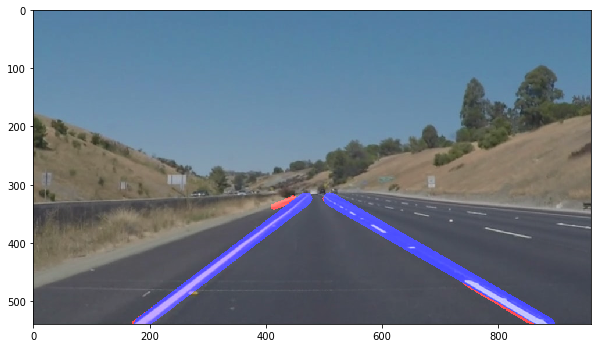

In [6]:
def detect_lanes_image(image_name):
    img = mpimg.imread(image_name)
    return process_image(img)

def show_all_files():
    files = os.listdir('test_images')
    for file in files:
        lanes = detect_lanes_image("test_images/{0}".format(file))
        plt.figure(figsize=(10,10))
        plt.imshow(lanes)
    plt.show()
    
def test_single(filename):
    lanes = detect_lanes_image(filename)

    plt.figure(figsize=(10,10))
    plt.imshow(lanes)
    plt.show()

show_all_files()

In [48]:
from moviepy.editor import VideoFileClip

def mark_lanes_video(video_filename):
    clip = VideoFileClip(video_filename)
    video_with_lanes = clip.fl_image(process_image)
    
    output = os.path.splitext(video_filename)
    %time video_with_lanes.write_videofile(output[0] + "-Lanes" + output[1], audio=False)
    
mark_lanes_video('solidWhiteRight.mp4')


[MoviePy] >>>> Building video solidWhiteRight-Lanes.mp4
[MoviePy] Writing video solidWhiteRight-Lanes.mp4


100%|█████████▉| 221/222 [00:02<00:00, 101.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight-Lanes.mp4 

CPU times: user 1.94 s, sys: 555 ms, total: 2.5 s
Wall time: 2.52 s
